In [24]:
import numpy as np
import math

In [28]:
"""
In this file I will compare 2 methods for calculating the nth fibonacci number
Fibonacci Sequence: 1 1 2 3 5 8 13 ... f(n) = f(n-1)+f(n-2)


1) Iterative solution using a loop

2) Recursive solution

note: in this case incorrect inputs (-inf,0] will still return the same as fib(1), but this would be trivial to change.

"""

def fib_1(n):
    prev = 0
    current = 1
    while n>1:
        temp = current
        current += prev
        prev = temp
        n -= 1
    return current


def fib_2_helper(prev,curr,n):
    if n>0: return fib_2_helper(curr, prev+curr, n-1)
    else: return curr

def fib_2(n):
    #fib_2 will need a helper function for the recursion
    return fib_2_helper(0,1,n-1)


# These will be useful for multiple fib functions
fib_matrix = np.matrix('1. 1;1 2')
start = np.matrix('0 1.')

def fib_3(n):
    n = n+1
    return np.linalg.matrix_power(fib_matrix.A, (n-1)//2).dot(start.A.T)[n%2-1][0]


# The following notes are more for me than for you, feel free to read them, although it's a little lengthy
'''
The previous functions were all written with help of Dr. Blanco-Silva.
The assignment in part 15, as written, is to create a fibonacci function
using PDP^(-1), as well as one that works using formulas.


For fib_4, I realized that LDU factorization is not applicable here. Instead, (I believe) I
need to use eigen factorization.

Eigen factorization results in VDV^-1, where D is a diagonal matrix of eigen values and the columns
of V are the eigen vectors.
'''
#In the spirit of numpy I'll use the built in function
D,V = np.linalg.eig(fib_matrix)
# the eigen values are stored in a 1D array, super easy to make it a diagonal matrix if you want that
# D = np.diag(D)   # not yet tho

#NOTE: I've been trying to resist googling simply 'fibonacci linear algebra approach'
'''
https://en.wikipedia.org/wiki/Matrix_decomposition

The final comment from the eigen factorization section is, I believe, the part that is relevant here:
Given an equation where x_t+1 = A*x_t, this can also be solved by x_t = A^t*x_0. However, if you use eigen factorization,
the formula becomes: x_t = V(D^t)V^-1*x_0. The advantage to this approach is that the values of D can be raised to the
't' power, which is significantly less expensive than raising a matrix to the 't' power. 

With this comment in mind, we can improve the efficiency of fib_3 by factorizing fib_matrix before the exponent
'''
# print(np.power(D*1.,7.35*10**3))
# print(D**735)
def fib_4(n):
    n = n+1

    # I usually like 1 liners, I'm not sure if its actually more efficient
    
    # Vinv = np.linalg.inv(V)
    # final_mat = V*(np.diag(D**((n-1)//2)))*Vinv
    # return final_mat.dot(start.A.T)[n%2-1][0]
    return (V*(np.diag((D**((n-1)//2)))*np.linalg.inv(V))).dot(start.A.T).A[n%2-1][0]

'''
I don't think my approach is wrong, but I'm being constrained by the data types. I will need to find a solution.
Here's some of the sources that I've found that seem to suggest I'm using the correct approach:
http://www.math.hawaii.edu/~pavel/fibonacci.pdf
https://medium.com/@andrew.chamberlain/the-linear-algebra-view-of-the-fibonacci-sequence-4e81f78935a3
http://web.media.mit.edu/~holbrow/post/calculating-fibonacci-numbers-with-matrices-and-linear-algebra/
'''
# even copying the exact 'solution' from the 3rd website listed gives the exact same error. shown below
lmbd_1 = (1+np.sqrt(5))/2
lmbd_2 = (1-np.sqrt(5))/2

a       = np.matrix([[1,      1],      [1,  0]])
s       = np.matrix([[lmbd_1, lmbd_2], [1,  1]])
s_inv   = np.matrix([[1,     -lmbd_2], [-1, lmbd_1]]) * (1/np.sqrt(5))
eig_val = np.matrix([[lmbd_1, 0],      [0,  lmbd_2]])
u_0     = np.matrix([[1],              [0]])

def eig_k(k):
    return eig_val ** k

def u_k(k):
    return s * eig_k(k) * s_inv * u_0

def fib_incorrect_solution(n):
    f_n = u_k(n)[1,0]
    return int(round(f_n))

'''
In the face of adversity we perservere. In this case, we can still improve the efficiency by finding the formulaic solution.

full disclosure: I'm learning this from the link:
http://www.math.hawaii.edu/~pavel/fibonacci.pdf
Which discusses kepler's obervation.
'''
# prepping the formula
# NOTE: most of the timeit comparisons I've seen show the standard ** to be faster than any .pow function in a package
# those functions are bad for efficiency, good for accuracy/flexibility (as far as I know)
def fib_5(n):
    Phi = (1+math.sqrt(5))/2
    phi = (1-math.sqrt(5))/2
    return (Phi**n-phi**n)/math.sqrt(5)

'''
Well, each solution works in a disapointingly limited manner. This will require more attention to fix,
but for now the linear algebra is mostle 
'''

In [29]:
fib_incorrect_solution(1500)

ValueError: cannot convert float NaN to integer

In [32]:
print('Testing the fib methods:\n1) {0}\n2) {1}\n3) {2}\n4) {3}'.format(fib_1(5),fib_5(5),fib_3(1475), fib_4(1475)))

Testing the fib methods:
1) 5
2) 5.000000000000001
3) 8.077637632156216e+307
4) 8.07763763215635e+307


In [7]:
# This function takes about twice as long to complete fib(1475)~22us as it does fib(10)~11us
%timeit fib_3(1475)

21.6 µs ± 209 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
# This function takes only 2 microseconds longer to complete fib(1475)~31us than fib(10)~29us
%timeit fib_4(1475)

29.8 µs ± 314 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
'''
Although the data types are preventing me from fully testing this,
it is clear that fib_4 is scaling much much better than fib_3 at larger values
'''
print()

In [11]:
# Simple example of how timeit can be used to get more accurate data
# variance can be conrtolled with n
# could use timeit or repeat

from timeit import repeat, timeit

setup = '''from __main__ import fib_1'''
my_code = '''fib_1(1000)'''

repeat(setup=setup, stmt=my_code, repeat=10, number= 800)
# timeit(setup=setup, stmt=my_code, number=10000)

[0.09125549606135763,
 0.08427385255075137,
 0.08350804156238212,
 0.08214818005018998,
 0.08271560952537271,
 0.08292894258642036,
 0.08220652755406377,
 0.0825507778269241,
 0.08216459028565026,
 0.08196766746007]

In [12]:
# While I know it's possible, I couldn't think of an elegant way to create a single method
# that would be able to time either fib1 or fib2 but not both at the same time. Instead,
# I will create separate methods (They will probably need different settings on timeit anyway)

# Both of the timer methods output to .txt files ultimately, things printed in this doc are for testing

from timeit import repeat

def fib_1_timeval(val, repetitions):
    setup = '''from __main__ import fib_1'''
    
    my_code = '''fib_1({0})'''.format(val)
    
    return timeit(setup=setup, stmt=my_code, number=repetitions)/repetitions

def fib_2_timeval(val, repetitions):
    setup = '''
from __main__ import fib_2
sys.setrecursionlimit(10**7)'''
    
    my_code = '''fib_2({0})'''.format(val)
    
    return timeit(setup=setup, stmt=my_code, number=repetitions)/repetitions

In [13]:
# The output is the average of 2000 trials
# each trial is the time of fib_1(1000)
fib_1_timeval(1000,2000)

0.0001105803716808893

In [14]:
fib_2_timeval(3000,2000) #too far above 3000 and my kernel crashes

0.0011776242063371925

In [15]:
# The next step is to automatically time an entire range of values.
# This brings up questions about syntax, would it be preferable to pass in a list of values to test?
# Perhaps a start val, end val, and a step between them? could be handled by range() + first construct
# How to set the precision of each value? -- for now I'll use the same for everything

def fib_1_timer(reps=10, startInd=1, endInd=1000, step=10):
    with open('fib1_times.txt','w') as write_file:
        for n in range(startInd, endInd+1, step):
            write_file.write('{0}\t{1}\n'.format(n,fib_1_timeval(n,reps)))
            
def fib_2_timer(reps=10, startInd=1, endInd=1000, step=10):
    with open('fib2_times.txt','w') as write_file:
        for n in range(startInd, endInd+1, step):
            write_file.write('{0}\t{1}\n'.format(n,fib_2_timeval(n,reps)))

In [16]:
# Even with 50 trials each repetition, there is significant variance
# But still pretty good.
# fib_1_timer(500,0,3000,5)
# fib_2_timer(500,0,3000,5)

In [17]:
# Now I will create a method to read the files I created and graph the data
import numpy as np
import re
import matplotlib.pyplot as plt


def graph_data(inFile):
    x = []
    y = []
    with open(inFile, 'r') as in_file:
        for line in in_file:
            tmp = re.split(r'\t', line)
            x.append(float(tmp[0]))
            y.append(float(tmp[1]))
            
    plt.ylim(0,y[-1]*1.2)
    
    plt.scatter(x, y)
    plt.show()


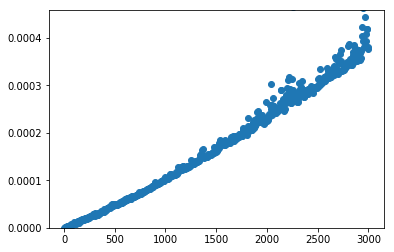

In [18]:
graph_data('fib1_times.txt')

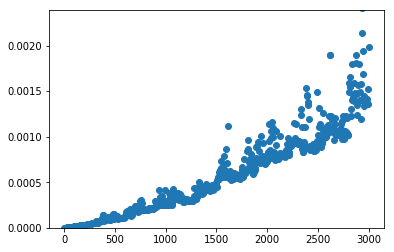

In [19]:
graph_data('fib2_times.txt')

In [20]:
fib_x(1500)

NameError: name 'fib_x' is not defined